<a href="https://colab.research.google.com/github/O-Kpy/Kaggle/blob/main/tabular_playground_series_sep_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
import scipy
from scipy.stats import skew

In [26]:
train = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-sep/tabular-playground-series-sep-2021_train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-sep/tabular-playground-series-sep-2021_test.csv')

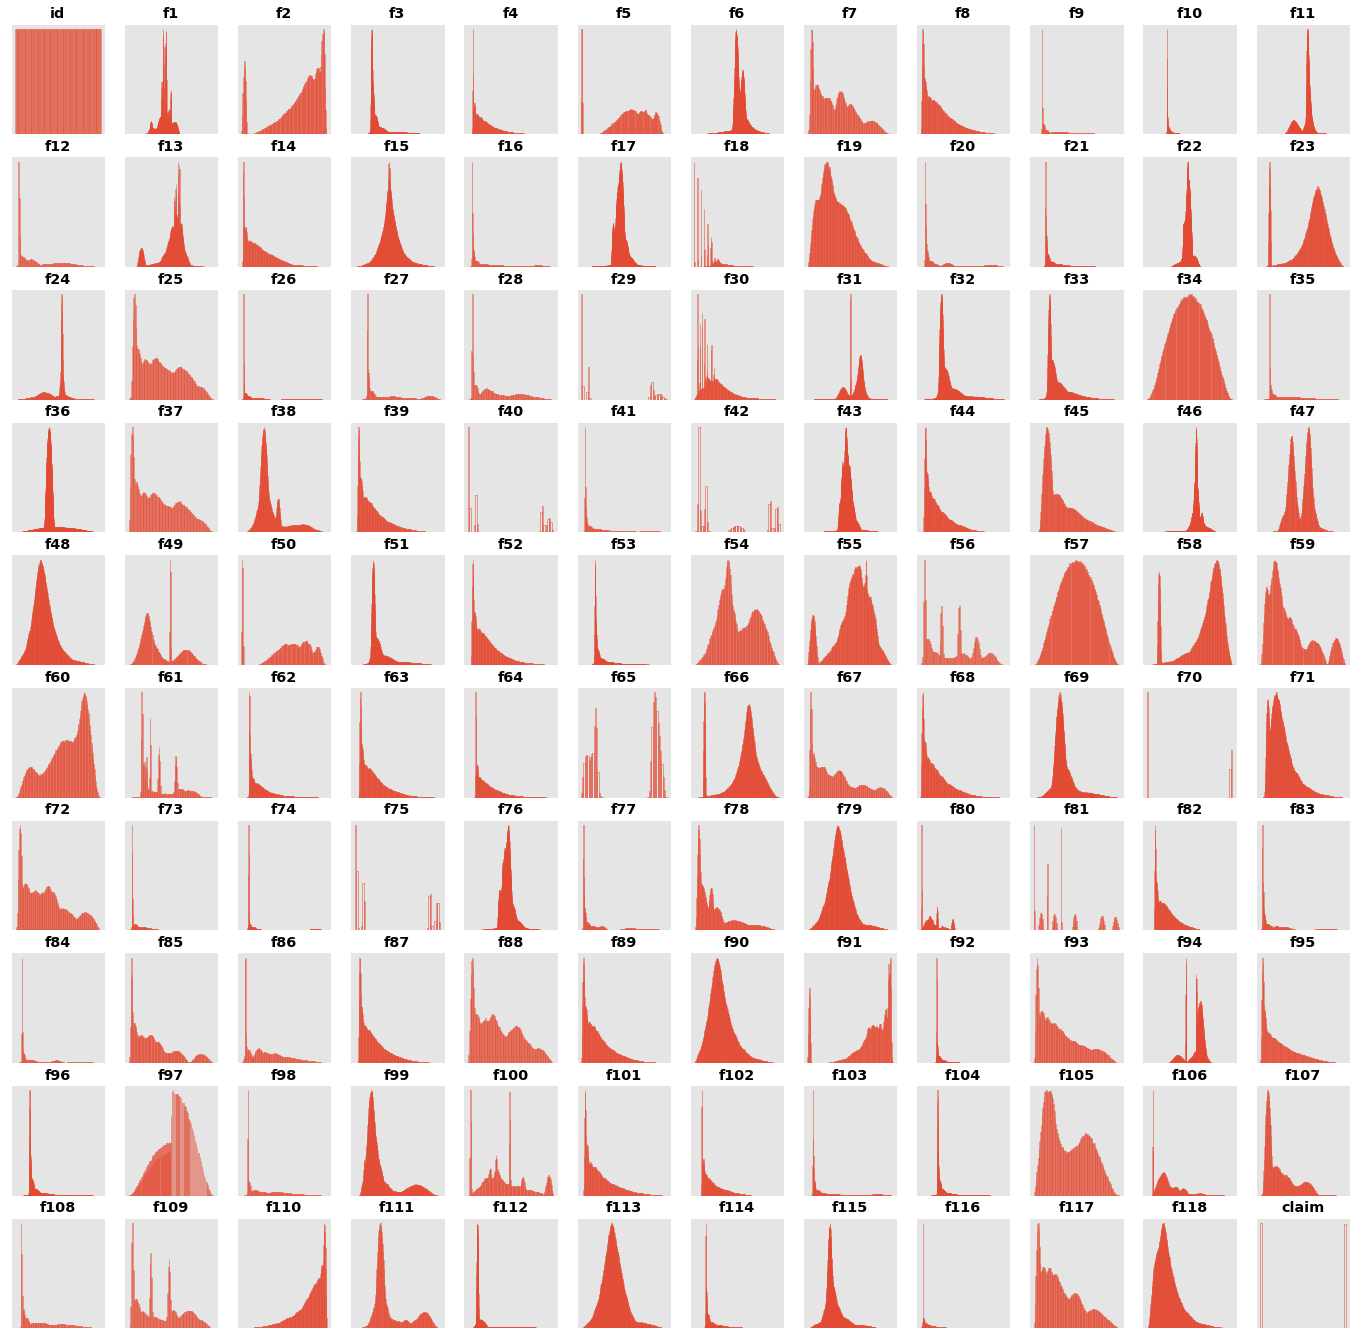

In [38]:
plt.figure(figsize=(24,24))
for i, j in enumerate(train.columns):
  plt.subplot(10, 12, i+1)
  sns.histplot(x=train[j], fill=False)
  plt.xlabel('')
  plt.ylabel('')
  plt.xticks([])
  plt.yticks([])
  plt.title(f'{j}', fontweight='bold')

In [27]:
train['na'] = train.isnull().sum(axis=1)
test['na'] = test.isnull().sum(axis=1)

In [4]:
!pip install catboost
!pip install optuna

In [28]:
from sklearn.impute import SimpleImputer
import catboost
import optuna
import lightgbm
import xgboost
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

In [29]:
# data splits

x_train = train.drop(columns=['claim', 'id'])
y_train = train['claim']
x_test = test.drop(columns=['id'])

train_columns = x_train.columns
test_columns = x_test.columns

In [30]:
# 누락값(impute)
x_train = pd.DataFrame(SimpleImputer(strategy='median').fit_transform(x_train), columns=train_columns)
x_test = pd.DataFrame(SimpleImputer(strategy='median').fit_transform(x_test), columns=test_columns)

In [31]:
# scaling
sc = StandardScaler().fit(x_train)
x_train = pd.DataFrame(sc.transform(x_train), columns=train_columns)
x_test = pd.DataFrame(sc.transform(x_test), columns=test_columns)

# Catboost

In [32]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
sf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
preds = 0

for i, (train_index, valid_index) in enumerate(sf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_cat = catboost.CatBoostClassifier(eval_metric='AUC', task_type='GPU', iterations=5000)
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)
  preds += model_cat.predict_proba(x_test)[:,1] / sf.n_splits

Learning rate set to 0.020796
0:	learn: 0.7998922	test: 0.7987854	best: 0.7987854 (0)	total: 41.8ms	remaining: 3m 28s
100:	learn: 0.8086191	test: 0.8067044	best: 0.8067044 (100)	total: 2.27s	remaining: 1m 50s
200:	learn: 0.8110949	test: 0.8082229	best: 0.8082229 (200)	total: 4.46s	remaining: 1m 46s
300:	learn: 0.8131639	test: 0.8094612	best: 0.8094612 (300)	total: 6.6s	remaining: 1m 43s
400:	learn: 0.8145601	test: 0.8102731	best: 0.8102731 (400)	total: 8.75s	remaining: 1m 40s
500:	learn: 0.8156883	test: 0.8108655	best: 0.8108655 (500)	total: 10.9s	remaining: 1m 37s
600:	learn: 0.8168249	test: 0.8114709	best: 0.8114709 (600)	total: 13s	remaining: 1m 34s
700:	learn: 0.8177605	test: 0.8118720	best: 0.8118720 (700)	total: 15.1s	remaining: 1m 32s
800:	learn: 0.8185911	test: 0.8122419	best: 0.8122419 (800)	total: 17.1s	remaining: 1m 29s
900:	learn: 0.8193662	test: 0.8125171	best: 0.8125171 (900)	total: 19.2s	remaining: 1m 27s
1000:	learn: 0.8200915	test: 0.8127798	best: 0.8127798 (1000)	tota

In [37]:
def objective(trial,data=x_train,target=y_train):
    
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2,random_state=42)
    params = {'iterations':trial.suggest_int("iterations", 2000, 40000, step=1000),
              'task_type':"GPU",
              'eval_metric':'AUC',
              'objective':'CrossEntropy',
              'leaf_estimation_method':'Newton',
              'bootstrap_type': 'Bernoulli',
              'learning_rate' : trial.suggest_uniform('learning_rate',0.01,0.5),
              'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
              'subsample': trial.suggest_uniform('subsample',0,1),
              'random_strength': trial.suggest_uniform('random_strength',10,50),
              'depth': trial.suggest_int('depth',1,13),
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
              'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
              'grow_policy' : 'Depthwise',
               }
    model = catboost.CatBoostClassifier(**params)  
    model.fit(X_train,y_train,eval_set=[(X_test,y_test)],early_stopping_rounds=100,verbose=False)
        
    y_preds = model.predict_proba(X_test)[:,1]


    AUC = roc_auc_score(y_test, y_preds)
    
    return AUC

In [38]:
OPTUNA_OPTIMIZATION = True

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print('Number of finished trials:', len(study.trials))
print('Best trial: score {}, params {}'.format(study.best_trial.value, study.best_trial.params))

[I 2021-09-09 12:14:11,833] A new study created in memory with name: no-name-840a91ba-6094-4900-85d1-3fb37c278a5d
[I 2021-09-09 12:14:20,548] Trial 0 finished with value: 0.8061893173830744 and parameters: {'iterations': 17000, 'learning_rate': 0.49162330473957433, 'reg_lambda': 71.28286817425976, 'subsample': 0.2397907861354578, 'random_strength': 31.07248025967134, 'depth': 9, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 3}. Best is trial 0 with value: 0.8061893173830744.
[I 2021-09-09 12:14:31,192] Trial 1 finished with value: 0.8051497551588823 and parameters: {'iterations': 15000, 'learning_rate': 0.3405809677490112, 'reg_lambda': 60.64382563983478, 'subsample': 0.39209078133918085, 'random_strength': 22.425601713140967, 'depth': 9, 'min_data_in_leaf': 18, 'leaf_estimation_iterations': 14}. Best is trial 0 with value: 0.8061893173830744.
[I 2021-09-09 12:14:43,599] Trial 2 finished with value: 0.8058756375408211 and parameters: {'iterations': 20000, 'learning_rate': 0.459

KeyboardInterrupt: ignored

In [16]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
sf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
preds = 0
params_cat = {
    'iterations'  :study.best_params['iterations'],
    'task_type':"GPU",
    'eval_metric':'AUC',
    'objective':'CrossEntropy',
    'leaf_estimation_method':'Newton',
    'bootstrap_type': 'Bernoulli',
    'learning_rate' : study.best_params['learning_rate'],
    'reg_lambda': study.best_params['reg_lambda'],
    'subsample': study.best_params['subsample'],
    'random_strength': study.best_params['random_strength'],
    'depth':study.best_params['depth'],
    'min_data_in_leaf': study.best_params['min_data_in_leaf'],
    'leaf_estimation_iterations': study.best_params['leaf_estimation_iterations'],
    'grow_policy' : 'Depthwise'
}

for i, (train_index, valid_index) in enumerate(sf.split(x_train, y_train)):
  X_train, X_valid = x_train.iloc[train_index], x_train.iloc[valid_index]
  Y_train, Y_valid = y_train.iloc[train_index], y_train.iloc[valid_index]

  model_cat = catboost.CatBoostClassifier(**params_cat)
  model_cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), verbose=100, early_stopping_rounds=70)
  preds += model_cat.predict_proba(x_test)[:,1] / sf.n_splits

0:	learn: 0.5173159	test: 0.5179257	best: 0.5179257 (0)	total: 25.5ms	remaining: 8m 29s
100:	learn: 0.6231683	test: 0.6188736	best: 0.6188736 (100)	total: 1.58s	remaining: 5m 11s
200:	learn: 0.6640435	test: 0.6595911	best: 0.6595911 (200)	total: 3.02s	remaining: 4m 58s
300:	learn: 0.6910128	test: 0.6861775	best: 0.6861775 (300)	total: 4.46s	remaining: 4m 51s
400:	learn: 0.7111189	test: 0.7061482	best: 0.7061482 (400)	total: 5.9s	remaining: 4m 48s
500:	learn: 0.7288172	test: 0.7240895	best: 0.7241096 (499)	total: 7.36s	remaining: 4m 46s
600:	learn: 0.7398074	test: 0.7351390	best: 0.7351390 (600)	total: 8.8s	remaining: 4m 44s
700:	learn: 0.7509472	test: 0.7462851	best: 0.7462851 (700)	total: 10.3s	remaining: 4m 42s
800:	learn: 0.7592449	test: 0.7547235	best: 0.7547761 (797)	total: 11.7s	remaining: 4m 40s
900:	learn: 0.7659265	test: 0.7615565	best: 0.7615874 (896)	total: 13.2s	remaining: 4m 39s
1000:	learn: 0.7719941	test: 0.7676869	best: 0.7676869 (1000)	total: 14.6s	remaining: 4m 37s
11

In [36]:
submit = pd.read_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-sep/tabular-playground-series-sep-2021_sample_solution.csv')
submit['claim'] = preds
submit.to_csv('/content/drive/MyDrive/dataset/kaggle/tabular-playground-series/2021-sep/submit3.csv', index=False)
submit

,id,claim
0,957919,0.586243
1,957920,0.119569
2,957921,0.620155
3,957922,0.129821
4,957923,0.140696
...,...,...
493469,1451388,0.827552
493470,1451389,0.119444
493471,1451390,0.754659
493472,1451391,0.129340
